In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import itertools
from PIL import Image

from sklearn.metrics import confusion_matrix
from tqdm import tqdm


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Parameters Configuration

In [16]:
LABELS = ['CompVis_stable-diffusion-v1-4', 'DeepFloyd_IF-II-L-v1.0', 'Real', 'stabilityai_stable-diffusion-2-1-base', 'stabilityai_stable-diffusion-xl-base-1.0', 'UNKNOWN']
REJ_SCORE = 00.7 # temp value
NUM_OF_CLASSES = len(LABELS)
IMG_SIZE = 224
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

BASE_PATH = '/content/drive/MyDrive/Computer-Vision'
MODEL_PATH = BASE_PATH + '/Models/FineTuning/model-8-Epochs.h5'

REJ_IMAGE_PATH = '/content/drive/MyDrive/Computer-Vision/RejectionScoreData/'

## Confusion Matrix

### Load Model

In [3]:
model = tf.keras.models.load_model(MODEL_PATH)

### Load Test Data

In [4]:
def format_image(image , label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

builder = tfds.folder_dataset.ImageFolder('/content/drive/MyDrive/Computer-Vision/Dataset/')
raw_test = builder.as_dataset(split='test', as_supervised=True)

info = builder.info

print("Total test images: {}  ".format(len(raw_test)) )
print("Label names: {}".format(info.features['label'].names))

test = raw_test.map(format_image)

test_batches = test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

Total test images: 4695  
Label names: ['CompVis_stable-diffusion-v1-4', 'DeepFloyd_IF-II-L-v1.0', 'Real', 'stabilityai_stable-diffusion-2-1-base', 'stabilityai_stable-diffusion-xl-base-1.0']


### Calculate predictions

In [18]:
true_labels = np.array([], dtype='int16')
predicted_labels = np.array([], dtype='int16')
rejection_threshold = 0.3


for image_batch, label_batch in tqdm(test_batches, total=len(test_batches), desc="Predicting: ", position=0, leave=True):
  for i in range(len(image_batch)):
    image = np.expand_dims(image_batch[i], axis=0)
    label = label_batch[i]

    prediction = model.predict(image,verbose = 0)
    predicted_class = np.argmax(prediction, axis=1)

    if(prediction[0][predicted_class] <= REJ_SCORE):
      predicted_classes = np.array([5], dtype='int16')

    true_labels = np.concatenate((true_labels, [label.numpy()]))
    predicted_labels = np.concatenate((predicted_labels, predicted_class))

Predicting: 100%|██████████| 147/147 [14:21<00:00,  5.86s/it]


### Rejection Score estimation


In [17]:
# init predicted label => all 5, representing the sixth category, 940 times
_, _, files = next(os.walk(REJ_IMAGE_PATH))
file_count = len(files)

avg_arg_max = np.array([])
r_true_labels = np.array([5]* file_count, dtype='int16')
r_predicted_labels = np.array([], dtype='int16')

for file in tqdm(os.listdir(REJ_IMAGE_PATH), desc="Processing images files", position=0, leave=True):
  filename = os.path.join(REJ_IMAGE_PATH,file)

  img = Image.open(filename)
  img = tf.cast(img, tf.float32)
  img = (img/127.5) - 1
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

  img = np.expand_dims(img, axis=0)  # Shape: (1, 224, 224, 3)

  predictions = model.predict(img,verbose = 0)
  predicted_classes = np.argmax(predictions, axis=1)ddd
  avg_arg_max = np.concatenate((avg_arg_max, np.array(predictions[0][predicted_classes])))

  if(predictions[0][predicted_classes] <= REJ_SCORE):
    predicted_classes = np.array([5], dtype='int16')

  r_predicted_labels = np.concatenate((r_predicted_labels, predicted_classes))


Processing images files:   0%|          | 2/940 [00:00<03:17,  4.75it/s]

[0.70483845]
[0.9481758]


Processing images files:   0%|          | 4/940 [00:00<02:47,  5.59it/s]

[0.5063744]
[0.951781]


Processing images files:   1%|          | 5/940 [00:00<03:01,  5.15it/s]

[0.5295332]


Processing images files:   1%|          | 6/940 [00:01<03:07,  4.99it/s]

[0.6341228]


Processing images files:   1%|          | 7/940 [00:01<03:13,  4.83it/s]

[0.7026971]


Processing images files:   1%|          | 9/940 [00:01<03:11,  4.86it/s]

[0.6115827]
[0.817475]


Processing images files:   1%|          | 10/940 [00:02<04:58,  3.12it/s]

[0.5494127]


Processing images files:   1%|▏         | 12/940 [00:10<28:57,  1.87s/it]

[0.57969904]
[0.6297321]


Processing images files:   1%|▏         | 14/940 [00:10<15:11,  1.02it/s]

[0.7547395]
[0.6199641]


Processing images files:   2%|▏         | 16/940 [00:10<08:30,  1.81it/s]

[0.50313145]
[0.58665407]


Processing images files:   2%|▏         | 17/940 [00:11<06:39,  2.31it/s]

[0.6674021]


Processing images files:   2%|▏         | 19/940 [00:12<08:26,  1.82it/s]

[0.5084]
[0.536927]


Processing images files:   2%|▏         | 21/940 [00:12<05:13,  2.93it/s]

[0.79238683]
[0.63690454]


Processing images files:   2%|▏         | 23/940 [00:13<03:38,  4.20it/s]

[0.546951]
[0.71467036]


Processing images files:   3%|▎         | 25/940 [00:14<05:15,  2.90it/s]

[0.75174314]
[0.6935963]


Processing images files:   3%|▎         | 27/940 [00:15<06:10,  2.46it/s]

[0.7972413]
[0.8281952]


Processing images files:   3%|▎         | 29/940 [00:15<04:10,  3.64it/s]

[0.85215145]
[0.5951988]


Processing images files:   3%|▎         | 31/940 [00:16<04:11,  3.61it/s]

[0.685215]
[0.5137102]


Processing images files:   3%|▎         | 32/940 [00:16<03:55,  3.85it/s]

[0.6242516]


Processing images files:   4%|▎         | 34/940 [00:16<03:31,  4.28it/s]

[0.6493365]
[0.7950295]


Processing images files:   4%|▎         | 35/940 [00:17<04:37,  3.26it/s]

[0.6103862]


Processing images files:   4%|▍         | 36/940 [00:17<04:56,  3.05it/s]

[0.7996664]


Processing images files:   4%|▍         | 37/940 [00:18<05:36,  2.68it/s]

[0.54583466]


Processing images files:   4%|▍         | 38/940 [00:18<06:04,  2.47it/s]

[0.6583873]


Processing images files:   4%|▍         | 39/940 [00:19<06:17,  2.39it/s]

[0.5148809]


Processing images files:   4%|▍         | 40/940 [00:19<06:39,  2.25it/s]

[0.6483741]


Processing images files:   4%|▍         | 41/940 [00:20<06:30,  2.30it/s]

[0.9955375]


Processing images files:   4%|▍         | 42/940 [00:20<05:52,  2.55it/s]

[0.6086836]


Processing images files:   5%|▍         | 43/940 [00:20<05:32,  2.70it/s]

[0.49639964]


Processing images files:   5%|▍         | 44/940 [00:21<07:51,  1.90it/s]

[0.84032905]


Processing images files:   5%|▍         | 45/940 [00:21<06:23,  2.33it/s]

[0.97863525]


Processing images files:   5%|▍         | 46/940 [00:22<05:39,  2.63it/s]

[0.5093872]


Processing images files:   5%|▌         | 47/940 [00:22<05:01,  2.96it/s]

[0.34894648]


Processing images files:   5%|▌         | 49/940 [00:22<04:00,  3.70it/s]

[0.52264374]
[0.46930578]


Processing images files:   5%|▌         | 51/940 [00:22<03:01,  4.90it/s]

[0.50525695]
[0.9999664]


Processing images files:   6%|▌         | 52/940 [00:23<02:46,  5.34it/s]

[0.45912215]


Processing images files:   6%|▌         | 54/940 [00:23<02:54,  5.08it/s]

[0.6760017]
[0.4844567]


Processing images files:   6%|▌         | 56/940 [00:24<02:55,  5.02it/s]

[0.55655056]
[0.6004206]


Processing images files:   6%|▌         | 58/940 [00:25<04:51,  3.02it/s]

[0.9237661]
[0.41926903]


Processing images files:   6%|▋         | 60/940 [00:25<03:25,  4.28it/s]

[0.99983335]
[0.7447726]


Processing images files:   7%|▋         | 62/940 [00:25<02:42,  5.39it/s]

[0.48836327]
[0.9998746]


Processing images files:   7%|▋         | 64/940 [00:25<02:28,  5.91it/s]

[0.7776539]
[0.5961429]


Processing images files:   7%|▋         | 66/940 [00:26<02:14,  6.48it/s]

[0.5459744]
[0.80412626]


Processing images files:   7%|▋         | 68/940 [00:27<04:29,  3.23it/s]

[0.4500172]
[0.7728342]


Processing images files:   7%|▋         | 70/940 [00:27<03:13,  4.50it/s]

[0.9821161]
[0.61942345]


Processing images files:   8%|▊         | 72/940 [00:27<02:40,  5.41it/s]

[0.6727593]
[0.56910086]


Processing images files:   8%|▊         | 74/940 [00:28<02:24,  5.99it/s]

[0.63753223]
[0.56758744]


Processing images files:   8%|▊         | 76/940 [00:28<02:16,  6.33it/s]

[0.97782713]
[0.7359552]


Processing images files:   8%|▊         | 78/940 [00:28<02:12,  6.52it/s]

[0.49547994]
[0.65086746]


Processing images files:   9%|▊         | 80/940 [00:29<02:10,  6.59it/s]

[0.7747202]
[0.6900554]


Processing images files:   9%|▊         | 81/940 [00:29<02:16,  6.28it/s]

[0.581903]


Processing images files:   9%|▊         | 82/940 [00:30<05:55,  2.41it/s]

[0.538874]


Processing images files:   9%|▉         | 83/940 [00:31<10:05,  1.41it/s]

[0.5809808]


Processing images files:   9%|▉         | 84/940 [00:31<08:00,  1.78it/s]

[0.7659943]


Processing images files:   9%|▉         | 85/940 [00:32<06:29,  2.19it/s]

[0.56699246]


Processing images files:   9%|▉         | 86/940 [00:32<05:29,  2.59it/s]

[0.9931289]


Processing images files:   9%|▉         | 87/940 [00:32<04:44,  3.00it/s]

[0.6150603]


Processing images files:   9%|▉         | 88/940 [00:32<04:17,  3.31it/s]

[0.99838185]


Processing images files:   9%|▉         | 89/940 [00:32<04:07,  3.44it/s]

[0.50821084]


Processing images files:  10%|▉         | 90/940 [00:33<03:46,  3.75it/s]

[0.3560428]


Processing images files:  10%|▉         | 91/940 [00:33<03:41,  3.83it/s]

[0.58219975]


Processing images files:  10%|▉         | 92/940 [00:33<03:32,  4.00it/s]

[0.58334506]


Processing images files:  10%|█         | 94/940 [00:34<03:11,  4.42it/s]

[0.5846311]
[0.5262607]


Processing images files:  10%|█         | 95/940 [00:34<03:11,  4.41it/s]

[0.6160538]


Processing images files:  10%|█         | 96/940 [00:34<03:39,  3.85it/s]

[0.5865412]


Processing images files:  10%|█         | 97/940 [00:35<08:20,  1.68it/s]

[0.6766409]


Processing images files:  10%|█         | 98/940 [00:36<06:55,  2.02it/s]

[0.5457344]


Processing images files:  11%|█         | 99/940 [00:36<06:04,  2.30it/s]

[0.5100155]


Processing images files:  11%|█         | 100/940 [00:36<05:29,  2.55it/s]

[0.6041296]


Processing images files:  11%|█         | 101/940 [00:37<05:01,  2.78it/s]

[0.5650184]


Processing images files:  11%|█         | 103/940 [00:37<03:58,  3.51it/s]

[0.9996333]
[0.5597893]


Processing images files:  11%|█         | 104/940 [00:37<03:41,  3.77it/s]

[0.9759182]


Processing images files:  11%|█         | 105/940 [00:37<03:28,  4.01it/s]

[0.99808913]


Processing images files:  11%|█▏        | 106/940 [00:38<03:20,  4.16it/s]

[0.5159003]


Processing images files:  11%|█▏        | 107/940 [00:38<05:00,  2.78it/s]

[0.80547845]


Processing images files:  11%|█▏        | 108/940 [00:39<06:12,  2.23it/s]

[0.6727766]


Processing images files:  12%|█▏        | 109/940 [00:40<06:41,  2.07it/s]

[0.58929247]


Processing images files:  12%|█▏        | 110/940 [00:40<06:06,  2.27it/s]

[0.6988384]


Processing images files:  12%|█▏        | 112/940 [00:40<04:28,  3.09it/s]

[0.56201637]
[0.80984247]


Processing images files:  12%|█▏        | 114/940 [00:41<03:19,  4.14it/s]

[0.6642013]
[0.7871621]


Processing images files:  12%|█▏        | 116/940 [00:41<02:52,  4.77it/s]

[0.41874433]
[0.5158648]


Processing images files:  13%|█▎        | 118/940 [00:41<02:30,  5.45it/s]

[0.46642599]
[0.99877506]


Processing images files:  13%|█▎        | 120/940 [00:42<02:22,  5.75it/s]

[0.38033363]
[0.9996486]


Processing images files:  13%|█▎        | 122/940 [00:42<02:16,  6.00it/s]

[0.9999443]
[0.9948427]


Processing images files:  13%|█▎        | 123/940 [00:42<02:46,  4.91it/s]

[0.68976605]


Processing images files:  13%|█▎        | 124/940 [00:43<03:07,  4.36it/s]

[0.7215729]


Processing images files:  13%|█▎        | 125/940 [00:43<03:43,  3.65it/s]

[0.5688443]


Processing images files:  13%|█▎        | 126/940 [00:43<03:41,  3.67it/s]

[0.39165512]


Processing images files:  14%|█▎        | 127/940 [00:44<03:47,  3.58it/s]

[0.5739037]


Processing images files:  14%|█▎        | 128/940 [00:44<03:54,  3.46it/s]

[0.7330845]


Processing images files:  14%|█▎        | 129/940 [00:44<04:00,  3.37it/s]

[0.6334471]


Processing images files:  14%|█▍        | 130/940 [00:45<05:12,  2.59it/s]

[0.9064002]


Processing images files:  14%|█▍        | 131/940 [00:45<06:05,  2.21it/s]

[0.62358063]


Processing images files:  14%|█▍        | 132/940 [00:46<07:52,  1.71it/s]

[0.5995953]


Processing images files:  14%|█▍        | 133/940 [00:47<09:22,  1.43it/s]

[0.97140366]


Processing images files:  14%|█▍        | 134/940 [00:48<09:55,  1.35it/s]

[0.51212645]


Processing images files:  14%|█▍        | 135/940 [00:49<10:28,  1.28it/s]

[0.9997651]


Processing images files:  14%|█▍        | 136/940 [00:49<09:17,  1.44it/s]

[0.53036535]


Processing images files:  15%|█▍        | 137/940 [00:50<08:27,  1.58it/s]

[0.6537247]


Processing images files:  15%|█▍        | 138/940 [00:50<07:45,  1.72it/s]

[0.91328514]


Processing images files:  15%|█▍        | 139/940 [00:51<07:18,  1.83it/s]

[0.5731177]


Processing images files:  15%|█▍        | 140/940 [00:51<06:21,  2.10it/s]

[1.]


Processing images files:  15%|█▌        | 141/940 [00:52<06:43,  1.98it/s]

[0.7109126]


Processing images files:  15%|█▌        | 142/940 [00:52<06:57,  1.91it/s]

[0.8524899]


Processing images files:  15%|█▌        | 143/940 [00:53<07:02,  1.89it/s]

[0.55155283]


Processing images files:  15%|█▌        | 144/940 [00:53<07:41,  1.73it/s]

[0.4479253]


Processing images files:  15%|█▌        | 145/940 [00:54<07:35,  1.74it/s]

[0.44340274]


Processing images files:  16%|█▌        | 146/940 [00:55<07:12,  1.84it/s]

[0.52616405]


Processing images files:  16%|█▌        | 147/940 [00:55<05:55,  2.23it/s]

[0.46918702]


Processing images files:  16%|█▌        | 148/940 [00:55<05:16,  2.50it/s]

[0.7366846]


Processing images files:  16%|█▌        | 149/940 [00:56<06:11,  2.13it/s]

[0.45936581]


Processing images files:  16%|█▌        | 150/940 [00:56<05:15,  2.50it/s]

[0.8958172]


Processing images files:  16%|█▌        | 151/940 [00:56<05:31,  2.38it/s]

[0.7407576]


Processing images files:  16%|█▌        | 152/940 [00:57<05:01,  2.61it/s]

[0.7757382]


Processing images files:  16%|█▋        | 154/940 [00:57<03:48,  3.44it/s]

[0.4636415]
[0.4926184]


Processing images files:  16%|█▋        | 155/940 [00:57<03:54,  3.34it/s]

[0.5218761]


Processing images files:  17%|█▋        | 156/940 [00:58<04:21,  3.00it/s]

[0.71581376]


Processing images files:  17%|█▋        | 157/940 [00:58<04:50,  2.69it/s]

[0.6944228]


Processing images files:  17%|█▋        | 158/940 [00:59<05:21,  2.43it/s]

[0.5073318]


Processing images files:  17%|█▋        | 159/940 [00:59<04:53,  2.66it/s]

[0.5291387]


Processing images files:  17%|█▋        | 160/940 [00:59<04:51,  2.68it/s]

[0.48481098]


Processing images files:  17%|█▋        | 161/940 [01:00<05:58,  2.17it/s]

[0.39005348]


Processing images files:  17%|█▋        | 162/940 [01:01<05:53,  2.20it/s]

[0.52710354]


Processing images files:  17%|█▋        | 163/940 [01:01<05:37,  2.30it/s]

[0.98261213]


Processing images files:  17%|█▋        | 164/940 [01:02<07:05,  1.82it/s]

[0.5219246]


Processing images files:  18%|█▊        | 165/940 [01:02<05:50,  2.21it/s]

[0.48763612]


Processing images files:  18%|█▊        | 166/940 [01:02<05:53,  2.19it/s]

[0.5643023]


Processing images files:  18%|█▊        | 167/940 [01:03<05:25,  2.38it/s]

[0.7897276]


Processing images files:  18%|█▊        | 168/940 [01:03<05:39,  2.28it/s]

[0.44334397]


Processing images files:  18%|█▊        | 169/940 [01:04<05:14,  2.45it/s]

[0.74157166]


Processing images files:  18%|█▊        | 170/940 [01:04<06:17,  2.04it/s]

[0.7523272]


Processing images files:  18%|█▊        | 171/940 [01:05<07:13,  1.78it/s]

[0.6121322]


Processing images files:  18%|█▊        | 172/940 [01:06<07:34,  1.69it/s]

[0.6666101]


Processing images files:  18%|█▊        | 173/940 [01:06<07:00,  1.82it/s]

[0.6456533]


Processing images files:  19%|█▊        | 174/940 [01:07<08:03,  1.58it/s]

[0.83698714]


Processing images files:  19%|█▊        | 175/940 [01:08<09:01,  1.41it/s]

[0.78326213]


Processing images files:  19%|█▊        | 176/940 [01:09<08:51,  1.44it/s]

[0.54596037]


Processing images files:  19%|█▉        | 177/940 [01:09<07:49,  1.62it/s]

[0.53006375]


Processing images files:  19%|█▉        | 178/940 [01:09<06:57,  1.82it/s]

[0.8380347]


Processing images files:  19%|█▉        | 179/940 [01:10<06:15,  2.02it/s]

[0.5390153]


Processing images files:  19%|█▉        | 180/940 [01:11<07:39,  1.65it/s]

[0.6787859]


Processing images files:  19%|█▉        | 181/940 [01:11<07:05,  1.79it/s]

[0.7817257]


Processing images files:  19%|█▉        | 182/940 [01:11<05:58,  2.11it/s]

[0.68656874]


Processing images files:  19%|█▉        | 183/940 [01:12<04:59,  2.53it/s]

[0.49986342]


Processing images files:  20%|█▉        | 184/940 [01:12<04:21,  2.90it/s]

[0.63831824]


Processing images files:  20%|█▉        | 185/940 [01:12<03:55,  3.21it/s]

[0.6537918]


Processing images files:  20%|█▉        | 186/940 [01:12<03:39,  3.44it/s]

[0.5329876]


Processing images files:  20%|█▉        | 187/940 [01:13<04:09,  3.01it/s]

[0.57201403]


Processing images files:  20%|██        | 189/940 [01:13<03:06,  4.03it/s]

[0.55616]
[0.99999845]


Processing images files:  20%|██        | 191/940 [01:13<02:27,  5.07it/s]

[0.55817056]
[0.64295214]


Processing images files:  21%|██        | 193/940 [01:14<02:05,  5.94it/s]

[0.51624334]
[0.56957155]


Processing images files:  21%|██        | 195/940 [01:14<01:54,  6.51it/s]

[0.9711159]
[0.56029075]


Processing images files:  21%|██        | 197/940 [01:14<01:49,  6.77it/s]

[0.6076972]
[0.55340016]


Processing images files:  21%|██        | 199/940 [01:15<02:05,  5.90it/s]

[0.88463014]
[0.56185347]


Processing images files:  21%|██▏       | 201/940 [01:15<01:55,  6.40it/s]

[0.55877304]
[0.59063375]


Processing images files:  22%|██▏       | 203/940 [01:15<01:52,  6.54it/s]

[0.74578595]
[0.70599914]


Processing images files:  22%|██▏       | 205/940 [01:15<01:50,  6.67it/s]

[0.6030098]
[0.6988522]


Processing images files:  22%|██▏       | 207/940 [01:16<01:50,  6.63it/s]

[0.7557933]
[0.64237493]


Processing images files:  22%|██▏       | 209/940 [01:16<01:52,  6.52it/s]

[0.7537415]
[0.7113241]


Processing images files:  22%|██▏       | 211/940 [01:16<01:46,  6.83it/s]

[0.7861244]
[0.51129174]


Processing images files:  23%|██▎       | 213/940 [01:17<02:05,  5.77it/s]

[0.80817246]
[0.99891055]


Processing images files:  23%|██▎       | 215/940 [01:17<02:01,  5.95it/s]

[0.66351354]
[0.6678545]


Processing images files:  23%|██▎       | 217/940 [01:17<01:54,  6.30it/s]

[0.5049083]
[0.6667505]


Processing images files:  23%|██▎       | 219/940 [01:18<01:52,  6.42it/s]

[0.69598234]
[0.6344878]


Processing images files:  24%|██▎       | 221/940 [01:18<01:50,  6.52it/s]

[0.6716371]
[0.5138628]


Processing images files:  24%|██▎       | 223/940 [01:18<01:44,  6.84it/s]

[0.7711223]
[0.99948764]


Processing images files:  24%|██▍       | 225/940 [01:19<01:41,  7.03it/s]

[0.43892518]
[0.7129601]


Processing images files:  24%|██▍       | 227/940 [01:19<01:45,  6.77it/s]

[0.5182153]
[0.55360097]


Processing images files:  24%|██▍       | 228/940 [01:19<02:15,  5.26it/s]

[0.81106144]


Processing images files:  24%|██▍       | 229/940 [01:20<03:11,  3.71it/s]

[0.63028175]


Processing images files:  24%|██▍       | 230/940 [01:20<03:42,  3.19it/s]

[0.9913833]


Processing images files:  25%|██▍       | 232/940 [01:20<03:00,  3.93it/s]

[0.9998596]
[0.9999578]


Processing images files:  25%|██▍       | 234/940 [01:21<02:18,  5.09it/s]

[0.6645242]
[0.6425066]


Processing images files:  25%|██▌       | 235/940 [01:21<02:20,  5.03it/s]

[0.57772255]


Processing images files:  25%|██▌       | 236/940 [01:21<02:22,  4.95it/s]

[0.6590395]


Processing images files:  25%|██▌       | 238/940 [01:22<02:25,  4.84it/s]

[0.57704175]
[0.5629757]


Processing images files:  25%|██▌       | 239/940 [01:22<02:23,  4.87it/s]

[0.99918956]


Processing images files:  26%|██▌       | 241/940 [01:22<02:22,  4.92it/s]

[0.78474003]
[0.8747961]


Processing images files:  26%|██▌       | 243/940 [01:23<02:22,  4.90it/s]

[0.63269824]
[0.48719108]


Processing images files:  26%|██▌       | 245/940 [01:23<02:18,  5.03it/s]

[0.49199706]
[0.41431564]


Processing images files:  26%|██▌       | 246/940 [01:23<02:20,  4.95it/s]

[0.8153065]


Processing images files:  26%|██▋       | 247/940 [01:24<03:07,  3.70it/s]

[0.73397315]


Processing images files:  26%|██▋       | 248/940 [01:24<02:56,  3.93it/s]

[0.999469]


Processing images files:  26%|██▋       | 249/940 [01:24<02:52,  4.01it/s]

[0.99999774]


Processing images files:  27%|██▋       | 250/940 [01:24<02:44,  4.20it/s]

[0.9999988]


Processing images files:  27%|██▋       | 252/940 [01:25<02:37,  4.36it/s]

[0.99872416]
[0.99872416]


Processing images files:  27%|██▋       | 253/940 [01:25<02:44,  4.17it/s]

[0.57542086]


Processing images files:  27%|██▋       | 255/940 [01:25<02:24,  4.74it/s]

[0.63300365]
[0.97617745]


Processing images files:  27%|██▋       | 257/940 [01:26<02:00,  5.65it/s]

[0.94193643]
[0.34261715]


Processing images files:  27%|██▋       | 258/940 [01:26<01:53,  6.01it/s]

[0.7405258]


Processing images files:  28%|██▊       | 260/940 [01:26<02:08,  5.30it/s]

[0.6529879]
[0.9999975]


Processing images files:  28%|██▊       | 262/940 [01:27<01:53,  5.98it/s]

[1.]
[0.5980938]


Processing images files:  28%|██▊       | 264/940 [01:27<01:44,  6.45it/s]

[0.57577217]
[0.9999999]


Processing images files:  28%|██▊       | 266/940 [01:27<01:41,  6.63it/s]

[0.99784446]
[0.99999666]


Processing images files:  29%|██▊       | 268/940 [01:27<01:38,  6.81it/s]

[0.99967444]
[0.9999963]


Processing images files:  29%|██▊       | 270/940 [01:28<01:40,  6.68it/s]

[0.9999994]
[0.630317]


Processing images files:  29%|██▉       | 272/940 [01:28<01:38,  6.78it/s]

[0.99980026]
[0.9999956]


Processing images files:  29%|██▉       | 273/940 [01:28<01:36,  6.88it/s]

[0.99999845]


Processing images files:  29%|██▉       | 275/940 [01:29<01:55,  5.78it/s]

[0.51418066]
[0.9984883]


Processing images files:  29%|██▉       | 277/940 [01:29<01:44,  6.33it/s]

[0.79744303]
[0.99863666]


Processing images files:  30%|██▉       | 279/940 [01:29<01:38,  6.72it/s]

[0.9789002]
[0.7935534]


Processing images files:  30%|██▉       | 281/940 [01:29<01:36,  6.86it/s]

[0.99614346]
[0.6957852]


Processing images files:  30%|███       | 282/940 [01:30<01:36,  6.85it/s]

[0.48918456]


Processing images files:  30%|███       | 284/940 [01:30<01:55,  5.70it/s]

[0.51379424]
[0.9999794]


Processing images files:  30%|███       | 286/940 [01:30<01:41,  6.46it/s]

[0.57495546]
[0.999928]


Processing images files:  31%|███       | 288/940 [01:31<01:36,  6.77it/s]

[0.54029584]
[0.8968234]


Processing images files:  31%|███       | 290/940 [01:31<01:34,  6.89it/s]

[0.99906033]
[0.9912288]


Processing images files:  31%|███       | 292/940 [01:31<01:30,  7.15it/s]

[0.9807896]
[0.99489045]


Processing images files:  31%|███▏      | 294/940 [01:31<01:32,  6.97it/s]

[0.99714416]
[0.6533296]


Processing images files:  31%|███▏      | 296/940 [01:32<01:36,  6.64it/s]

[0.61522424]
[0.65484285]


Processing images files:  32%|███▏      | 298/940 [01:32<01:54,  5.61it/s]

[0.6513806]
[0.5309835]


Processing images files:  32%|███▏      | 300/940 [01:32<01:41,  6.33it/s]

[0.9474889]
[0.7890688]


Processing images files:  32%|███▏      | 302/940 [01:33<01:42,  6.25it/s]

[0.67945623]
[0.70316076]


Processing images files:  32%|███▏      | 304/940 [01:33<01:39,  6.39it/s]

[0.6266892]
[0.99953043]


Processing images files:  33%|███▎      | 306/940 [01:33<01:35,  6.66it/s]

[0.6578534]
[0.99998677]


Processing images files:  33%|███▎      | 308/940 [01:34<01:33,  6.74it/s]

[0.74481636]
[0.64979273]


Processing images files:  33%|███▎      | 310/940 [01:34<01:45,  5.94it/s]

[0.6773062]
[0.5378495]


Processing images files:  33%|███▎      | 312/940 [01:34<01:51,  5.64it/s]

[0.714951]
[0.6109757]


Processing images files:  33%|███▎      | 314/940 [01:35<01:46,  5.89it/s]

[0.5008328]
[0.55138093]


Processing images files:  34%|███▎      | 316/940 [01:35<01:40,  6.19it/s]

[0.5268436]
[0.67228734]


Processing images files:  34%|███▎      | 317/940 [01:35<01:38,  6.30it/s]

[0.93892115]


Processing images files:  34%|███▍      | 318/940 [01:35<01:52,  5.51it/s]

[0.38359326]


Processing images files:  34%|███▍      | 319/940 [01:36<01:59,  5.20it/s]

[0.99897563]


Processing images files:  34%|███▍      | 320/940 [01:36<02:09,  4.80it/s]

[0.62363034]


Processing images files:  34%|███▍      | 321/940 [01:36<02:11,  4.72it/s]

[0.63568586]


Processing images files:  34%|███▍      | 323/940 [01:37<02:08,  4.80it/s]

[0.58287686]
[1.]


Processing images files:  34%|███▍      | 324/940 [01:37<02:26,  4.19it/s]

[0.6619606]


Processing images files:  35%|███▍      | 325/940 [01:37<02:30,  4.10it/s]

[0.5862121]


Processing images files:  35%|███▍      | 326/940 [01:37<02:24,  4.25it/s]

[0.56092584]


Processing images files:  35%|███▍      | 327/940 [01:38<02:20,  4.37it/s]

[0.42352176]


Processing images files:  35%|███▍      | 328/940 [01:38<02:23,  4.26it/s]

[0.4477803]


Processing images files:  35%|███▌      | 329/940 [01:38<02:23,  4.26it/s]

[0.6807765]


Processing images files:  35%|███▌      | 330/940 [01:38<02:21,  4.30it/s]

[0.69152594]


Processing images files:  35%|███▌      | 331/940 [01:38<02:22,  4.28it/s]

[0.58499324]


Processing images files:  35%|███▌      | 332/940 [01:39<02:21,  4.29it/s]

[0.9898341]


Processing images files:  35%|███▌      | 333/940 [01:39<02:18,  4.38it/s]

[0.54910016]


Processing images files:  36%|███▌      | 334/940 [01:39<02:23,  4.21it/s]

[0.35766605]


Processing images files:  36%|███▌      | 335/940 [01:39<02:20,  4.31it/s]

[0.99738735]


Processing images files:  36%|███▌      | 337/940 [01:40<02:06,  4.77it/s]

[0.62594503]
[0.5707306]


Processing images files:  36%|███▌      | 339/940 [01:40<01:48,  5.55it/s]

[0.99751437]
[0.7991316]


Processing images files:  36%|███▋      | 341/940 [01:40<01:39,  5.99it/s]

[0.99999285]
[0.99704957]


Processing images files:  36%|███▋      | 343/940 [01:41<01:34,  6.29it/s]

[0.5757807]
[0.9954724]


Processing images files:  37%|███▋      | 345/940 [01:41<01:30,  6.55it/s]

[0.69912463]
[0.6858276]


Processing images files:  37%|███▋      | 347/940 [01:41<01:27,  6.77it/s]

[0.99759847]
[0.9601385]


Processing images files:  37%|███▋      | 349/940 [01:42<01:27,  6.76it/s]

[0.9990563]
[0.99808335]


Processing images files:  37%|███▋      | 351/940 [01:42<01:27,  6.73it/s]

[0.53862435]
[0.55123556]


Processing images files:  38%|███▊      | 353/940 [01:42<01:26,  6.77it/s]

[0.61516964]
[0.49434504]


Processing images files:  38%|███▊      | 355/940 [01:42<01:26,  6.79it/s]

[0.5738693]
[0.7001388]


Processing images files:  38%|███▊      | 357/940 [01:43<01:23,  6.95it/s]

[0.51044387]
[0.872436]


Processing images files:  38%|███▊      | 359/940 [01:43<01:26,  6.70it/s]

[0.4621789]
[0.53875035]


Processing images files:  38%|███▊      | 361/940 [01:43<01:24,  6.83it/s]

[0.6584258]
[0.6567425]


Processing images files:  39%|███▊      | 363/940 [01:44<01:24,  6.84it/s]

[0.784149]
[0.7399776]


Processing images files:  39%|███▉      | 365/940 [01:44<01:23,  6.85it/s]

[0.9988201]
[0.5614183]


Processing images files:  39%|███▉      | 367/940 [01:44<01:43,  5.53it/s]

[0.5193201]
[0.54394794]


Processing images files:  39%|███▉      | 369/940 [01:45<01:58,  4.82it/s]

[0.99903995]
[0.60004675]


Processing images files:  39%|███▉      | 371/940 [01:45<01:41,  5.63it/s]

[0.64058733]
[0.90847594]


Processing images files:  40%|███▉      | 373/940 [01:46<01:45,  5.39it/s]

[0.55111307]
[0.60471505]


Processing images files:  40%|███▉      | 375/940 [01:46<01:33,  6.07it/s]

[0.7047891]
[0.5054873]


Processing images files:  40%|████      | 377/940 [01:46<01:27,  6.46it/s]

[0.6015885]
[0.59365046]


Processing images files:  40%|████      | 378/940 [01:46<01:26,  6.51it/s]

[0.43377176]


Processing images files:  40%|████      | 379/940 [01:47<01:48,  5.19it/s]

[0.3398871]


Processing images files:  40%|████      | 380/940 [01:47<02:12,  4.24it/s]

[0.6727476]


Processing images files:  41%|████      | 381/940 [01:47<02:27,  3.78it/s]

[0.7062127]


Processing images files:  41%|████      | 382/940 [01:48<02:34,  3.62it/s]

[0.75385445]


Processing images files:  41%|████      | 384/940 [01:48<02:24,  3.85it/s]

[0.83117485]
[0.6573652]


Processing images files:  41%|████      | 386/940 [01:48<01:56,  4.77it/s]

[0.9999752]
[0.53664297]


Processing images files:  41%|████      | 387/940 [01:49<02:07,  4.35it/s]

[0.55877733]


Processing images files:  41%|████▏     | 388/940 [01:49<02:22,  3.88it/s]

[0.6588958]


Processing images files:  41%|████▏     | 389/940 [01:49<02:31,  3.63it/s]

[0.58503836]


Processing images files:  41%|████▏     | 390/940 [01:50<02:34,  3.55it/s]

[0.47969276]


Processing images files:  42%|████▏     | 392/940 [01:50<02:38,  3.47it/s]

[0.40392077]
[0.69747305]


Processing images files:  42%|████▏     | 393/940 [01:51<03:01,  3.01it/s]

[0.6863052]


Processing images files:  42%|████▏     | 394/940 [01:51<02:44,  3.32it/s]

[0.99879813]


Processing images files:  42%|████▏     | 395/940 [01:51<02:32,  3.58it/s]

[0.6087187]


Processing images files:  42%|████▏     | 396/940 [01:51<02:22,  3.83it/s]

[0.65551466]


Processing images files:  42%|████▏     | 397/940 [01:52<02:15,  4.02it/s]

[0.5890846]


Processing images files:  42%|████▏     | 398/940 [01:52<02:13,  4.07it/s]

[0.90001476]


Processing images files:  42%|████▏     | 399/940 [01:52<02:07,  4.24it/s]

[0.967755]


Processing images files:  43%|████▎     | 400/940 [01:52<02:20,  3.85it/s]

[0.70560074]


Processing images files:  43%|████▎     | 401/940 [01:53<02:19,  3.87it/s]

[0.8542722]


Processing images files:  43%|████▎     | 402/940 [01:53<02:14,  4.00it/s]

[0.6292139]


Processing images files:  43%|████▎     | 403/940 [01:53<02:30,  3.57it/s]

[0.65416193]


Processing images files:  43%|████▎     | 404/940 [01:53<02:27,  3.62it/s]

[0.8907527]


Processing images files:  43%|████▎     | 406/940 [01:54<02:10,  4.09it/s]

[0.5066801]
[0.59051037]


Processing images files:  43%|████▎     | 407/940 [01:54<02:02,  4.36it/s]

[0.55024403]


Processing images files:  44%|████▎     | 409/940 [01:54<01:47,  4.93it/s]

[0.8071308]
[0.5736916]


Processing images files:  44%|████▎     | 411/940 [01:55<01:34,  5.60it/s]

[0.5705101]
[0.9841771]


Processing images files:  44%|████▍     | 413/940 [01:55<01:29,  5.90it/s]

[0.6239684]
[0.61383617]


Processing images files:  44%|████▍     | 415/940 [01:55<01:22,  6.33it/s]

[0.7652333]
[0.6058045]


Processing images files:  44%|████▍     | 417/940 [01:56<01:22,  6.36it/s]

[0.9999958]
[0.9999958]


Processing images files:  45%|████▍     | 419/940 [01:56<01:20,  6.47it/s]

[0.99967575]
[0.5531331]


Processing images files:  45%|████▍     | 421/940 [01:56<01:31,  5.68it/s]

[0.5047064]
[0.99999976]


Processing images files:  45%|████▌     | 423/940 [01:57<01:24,  6.12it/s]

[0.9995758]
[0.8892826]


Processing images files:  45%|████▌     | 424/940 [01:57<01:22,  6.26it/s]

[0.9968945]


Processing images files:  45%|████▌     | 425/940 [01:57<01:39,  5.18it/s]

[0.6410512]


Processing images files:  45%|████▌     | 426/940 [01:57<01:50,  4.64it/s]

[0.67064947]


Processing images files:  45%|████▌     | 427/940 [01:58<02:02,  4.18it/s]

[0.69123054]


Processing images files:  46%|████▌     | 428/940 [01:58<02:08,  4.00it/s]

[0.54803354]


Processing images files:  46%|████▌     | 429/940 [01:58<02:15,  3.76it/s]

[0.63088423]


Processing images files:  46%|████▌     | 431/940 [01:59<01:58,  4.28it/s]

[0.5239537]
[0.6256305]


Processing images files:  46%|████▌     | 432/940 [01:59<01:47,  4.72it/s]

[0.64985985]


Processing images files:  46%|████▌     | 433/940 [01:59<01:56,  4.37it/s]

[0.6969846]


Processing images files:  46%|████▌     | 434/940 [01:59<02:03,  4.09it/s]

[0.8074205]


Processing images files:  46%|████▋     | 435/940 [02:00<02:09,  3.91it/s]

[0.56092745]


Processing images files:  46%|████▋     | 436/940 [02:00<02:19,  3.62it/s]

[0.7397584]


Processing images files:  47%|████▋     | 438/940 [02:00<01:57,  4.28it/s]

[0.73319536]
[0.5375742]


Processing images files:  47%|████▋     | 439/940 [02:01<02:04,  4.01it/s]

[0.58174485]


Processing images files:  47%|████▋     | 440/940 [02:01<02:14,  3.71it/s]

[0.5922903]


Processing images files:  47%|████▋     | 442/940 [02:01<01:53,  4.40it/s]

[0.7340346]
[0.96879464]


Processing images files:  47%|████▋     | 444/940 [02:02<01:44,  4.76it/s]

[0.7844372]
[0.59757656]


Processing images files:  47%|████▋     | 446/940 [02:02<01:37,  5.06it/s]

[0.5026404]
[0.4893384]


Processing images files:  48%|████▊     | 448/940 [02:03<01:35,  5.13it/s]

[0.7368705]
[0.99546415]


Processing images files:  48%|████▊     | 450/940 [02:03<01:24,  5.82it/s]

[0.3747039]
[0.9949811]


Processing images files:  48%|████▊     | 452/940 [02:03<01:15,  6.43it/s]

[0.60455036]
[0.5833847]


Processing images files:  48%|████▊     | 454/940 [02:04<01:11,  6.75it/s]

[0.5749897]
[0.9861783]


Processing images files:  49%|████▊     | 456/940 [02:04<01:07,  7.14it/s]

[0.5728511]
[0.96716577]


Processing images files:  49%|████▊     | 457/940 [02:05<02:29,  3.22it/s]

[0.63326555]


Processing images files:  49%|████▊     | 458/940 [02:05<02:17,  3.51it/s]

[0.7019617]


Processing images files:  49%|████▉     | 459/940 [02:05<02:05,  3.84it/s]

[0.38619688]


Processing images files:  49%|████▉     | 461/940 [02:05<01:51,  4.29it/s]

[0.7301851]
[0.5668094]


Processing images files:  49%|████▉     | 463/940 [02:06<01:40,  4.73it/s]

[0.5363603]
[0.51183]


Processing images files:  49%|████▉     | 464/940 [02:06<01:44,  4.57it/s]

[0.49149227]


Processing images files:  49%|████▉     | 465/940 [02:07<03:37,  2.19it/s]

[0.6137263]


Processing images files:  50%|████▉     | 466/940 [02:07<03:24,  2.32it/s]

[0.51117796]


Processing images files:  50%|████▉     | 467/940 [02:08<02:52,  2.74it/s]

[0.96882176]


Processing images files:  50%|████▉     | 468/940 [02:09<04:16,  1.84it/s]

[0.73006576]


Processing images files:  50%|█████     | 470/940 [02:09<03:22,  2.32it/s]

[0.57862616]
[0.96503407]


Processing images files:  50%|█████     | 472/940 [02:10<02:47,  2.80it/s]

[0.7260377]
[0.91854626]


Processing images files:  50%|█████     | 473/940 [02:10<02:33,  3.05it/s]

[0.63725513]


Processing images files:  50%|█████     | 474/940 [02:10<02:35,  3.01it/s]

[0.546563]


Processing images files:  51%|█████     | 475/940 [02:11<02:31,  3.06it/s]

[0.60368305]


Processing images files:  51%|█████     | 476/940 [02:11<02:33,  3.03it/s]

[0.51252353]


Processing images files:  51%|█████     | 478/940 [02:12<02:06,  3.67it/s]

[0.65422153]
[0.511269]


Processing images files:  51%|█████     | 479/940 [02:12<02:08,  3.58it/s]

[0.5368875]


Processing images files:  51%|█████     | 480/940 [02:12<02:13,  3.44it/s]

[0.7820126]


Processing images files:  51%|█████▏    | 482/940 [02:13<01:56,  3.93it/s]

[0.4898163]
[0.9273617]


Processing images files:  51%|█████▏    | 484/940 [02:13<01:46,  4.28it/s]

[0.6727344]
[0.99959534]


Processing images files:  52%|█████▏    | 486/940 [02:13<01:26,  5.23it/s]

[0.77317286]
[0.79843843]


Processing images files:  52%|█████▏    | 488/940 [02:14<01:18,  5.77it/s]

[0.87063074]
[0.6676061]


Processing images files:  52%|█████▏    | 490/940 [02:14<01:13,  6.16it/s]

[0.79437906]
[0.6177527]


Processing images files:  52%|█████▏    | 492/940 [02:14<01:09,  6.49it/s]

[0.70846134]
[0.8423935]


Processing images files:  53%|█████▎    | 494/940 [02:15<01:09,  6.41it/s]

[0.9700733]
[0.84813106]


Processing images files:  53%|█████▎    | 496/940 [02:15<01:07,  6.59it/s]

[0.58496857]
[0.6542363]


Processing images files:  53%|█████▎    | 498/940 [02:15<01:04,  6.84it/s]

[0.3430732]
[0.58631235]


Processing images files:  53%|█████▎    | 500/940 [02:16<01:13,  6.02it/s]

[0.54801977]
[0.69775337]


Processing images files:  53%|█████▎    | 502/940 [02:16<01:07,  6.51it/s]

[0.66770613]
[0.52344984]


Processing images files:  54%|█████▎    | 504/940 [02:16<01:04,  6.72it/s]

[0.57203615]
[0.76803124]


Processing images files:  54%|█████▎    | 505/940 [02:16<01:02,  6.96it/s]

[0.48746264]


Processing images files:  54%|█████▍    | 507/940 [02:17<01:17,  5.61it/s]

[0.48031372]
[0.86762446]


Processing images files:  54%|█████▍    | 509/940 [02:17<01:09,  6.18it/s]

[0.5483599]
[0.58635616]


Processing images files:  54%|█████▍    | 511/940 [02:17<01:06,  6.42it/s]

[0.53151137]
[0.59265035]


Processing images files:  55%|█████▍    | 513/940 [02:18<01:09,  6.18it/s]

[0.8910169]
[0.5213029]


Processing images files:  55%|█████▍    | 515/940 [02:18<01:07,  6.27it/s]

[0.51144254]
[0.5549375]


Processing images files:  55%|█████▌    | 517/940 [02:18<01:06,  6.41it/s]

[0.7783968]
[0.5872843]


Processing images files:  55%|█████▌    | 519/940 [02:19<01:04,  6.55it/s]

[0.5399147]
[0.9663608]


Processing images files:  55%|█████▌    | 521/940 [02:19<01:06,  6.32it/s]

[0.6155003]
[0.5750391]


Processing images files:  56%|█████▌    | 523/940 [02:19<01:03,  6.62it/s]

[0.5478964]
[0.5780969]


Processing images files:  56%|█████▌    | 525/940 [02:20<01:17,  5.37it/s]

[0.6582224]
[0.9976344]


Processing images files:  56%|█████▌    | 526/940 [02:20<01:15,  5.50it/s]

[0.4816264]


Processing images files:  56%|█████▌    | 527/940 [02:20<01:19,  5.17it/s]

[0.99935263]


Processing images files:  56%|█████▌    | 528/940 [02:20<01:34,  4.35it/s]

[0.57161534]


Processing images files:  56%|█████▋    | 529/940 [02:21<01:34,  4.36it/s]

[0.46213743]


Processing images files:  56%|█████▋    | 530/940 [02:21<01:35,  4.28it/s]

[0.67427796]


Processing images files:  56%|█████▋    | 531/940 [02:21<01:40,  4.08it/s]

[0.5126021]


Processing images files:  57%|█████▋    | 532/940 [02:21<01:45,  3.86it/s]

[0.5852813]


Processing images files:  57%|█████▋    | 533/940 [02:22<02:33,  2.65it/s]

[0.7042282]


Processing images files:  57%|█████▋    | 534/940 [02:23<03:10,  2.13it/s]

[0.7339037]


Processing images files:  57%|█████▋    | 535/940 [02:23<02:53,  2.33it/s]

[0.5734234]


Processing images files:  57%|█████▋    | 536/940 [02:23<02:30,  2.68it/s]

[0.58808386]


Processing images files:  57%|█████▋    | 537/940 [02:24<02:20,  2.87it/s]

[0.5597607]


Processing images files:  57%|█████▋    | 538/940 [02:24<02:09,  3.10it/s]

[0.66497856]


Processing images files:  57%|█████▋    | 539/940 [02:24<02:02,  3.28it/s]

[0.51876444]


Processing images files:  57%|█████▋    | 540/940 [02:24<01:58,  3.37it/s]

[0.54447186]


Processing images files:  58%|█████▊    | 541/940 [02:25<01:48,  3.67it/s]

[0.602387]


Processing images files:  58%|█████▊    | 542/940 [02:25<01:42,  3.88it/s]

[0.56367093]


Processing images files:  58%|█████▊    | 543/940 [02:25<01:38,  4.02it/s]

[0.55862886]


Processing images files:  58%|█████▊    | 544/940 [02:26<02:02,  3.24it/s]

[0.6306339]


Processing images files:  58%|█████▊    | 545/940 [02:26<01:50,  3.57it/s]

[0.5259526]


Processing images files:  58%|█████▊    | 546/940 [02:26<01:47,  3.67it/s]

[0.5131805]


Processing images files:  58%|█████▊    | 547/940 [02:26<01:46,  3.69it/s]

[0.53365403]


Processing images files:  58%|█████▊    | 548/940 [02:27<01:45,  3.71it/s]

[0.5463039]


Processing images files:  58%|█████▊    | 549/940 [02:27<01:44,  3.73it/s]

[0.7521042]


Processing images files:  59%|█████▊    | 550/940 [02:27<01:38,  3.94it/s]

[0.52218777]
[0.6617404]


Processing images files:  59%|█████▊    | 552/940 [02:28<01:46,  3.64it/s]

[0.5374173]


Processing images files:  59%|█████▉    | 554/940 [02:28<01:38,  3.92it/s]

[0.53183997]
[0.54953504]


Processing images files:  59%|█████▉    | 555/940 [02:28<01:27,  4.39it/s]

[0.9999994]


Processing images files:  59%|█████▉    | 556/940 [02:29<01:35,  4.01it/s]

[0.79214716]


Processing images files:  59%|█████▉    | 557/940 [02:29<01:40,  3.80it/s]

[0.5511946]


Processing images files:  59%|█████▉    | 558/940 [02:29<01:43,  3.70it/s]

[0.67230946]


Processing images files:  59%|█████▉    | 559/940 [02:29<01:45,  3.60it/s]

[0.5401511]


Processing images files:  60%|█████▉    | 560/940 [02:30<01:43,  3.66it/s]

[0.9920438]


Processing images files:  60%|█████▉    | 561/940 [02:30<01:43,  3.66it/s]

[0.9906625]


Processing images files:  60%|█████▉    | 562/940 [02:30<01:44,  3.63it/s]

[0.47887585]


Processing images files:  60%|█████▉    | 563/940 [02:31<01:45,  3.57it/s]

[0.9705906]


Processing images files:  60%|██████    | 564/940 [02:31<01:44,  3.61it/s]

[0.989688]


Processing images files:  60%|██████    | 566/940 [02:31<01:26,  4.33it/s]

[0.55272573]
[0.50655705]


Processing images files:  60%|██████    | 567/940 [02:32<01:35,  3.90it/s]

[0.79047084]


Processing images files:  60%|██████    | 568/940 [02:32<01:38,  3.79it/s]

[0.50287575]


Processing images files:  61%|██████    | 569/940 [02:32<01:39,  3.74it/s]

[0.9821755]


Processing images files:  61%|██████    | 570/940 [02:32<01:40,  3.68it/s]

[0.76855266]


Processing images files:  61%|██████    | 572/940 [02:33<01:29,  4.09it/s]

[0.99928373]
[0.5672817]


Processing images files:  61%|██████    | 574/940 [02:33<01:12,  5.08it/s]

[0.70285404]
[0.81856537]


Processing images files:  61%|██████    | 575/940 [02:33<01:08,  5.32it/s]

[0.5397891]


Processing images files:  61%|██████▏   | 576/940 [02:34<02:43,  2.23it/s]

[0.9929101]


Processing images files:  61%|██████▏   | 577/940 [02:36<04:24,  1.37it/s]

[0.61655545]


Processing images files:  61%|██████▏   | 578/940 [02:36<03:35,  1.68it/s]

[0.6647322]


Processing images files:  62%|██████▏   | 579/940 [02:36<03:02,  1.98it/s]

[0.9956943]


Processing images files:  62%|██████▏   | 580/940 [02:37<02:38,  2.28it/s]

[0.9971156]


Processing images files:  62%|██████▏   | 581/940 [02:37<02:19,  2.57it/s]

[0.99997985]


Processing images files:  62%|██████▏   | 582/940 [02:37<02:18,  2.58it/s]

[0.9999802]


Processing images files:  62%|██████▏   | 583/940 [02:38<02:23,  2.49it/s]

[0.70516586]


Processing images files:  62%|██████▏   | 584/940 [02:38<02:30,  2.37it/s]

[0.514279]


Processing images files:  62%|██████▏   | 585/940 [02:39<02:33,  2.31it/s]

[0.91802716]


Processing images files:  62%|██████▏   | 586/940 [02:39<02:38,  2.23it/s]

[0.53548783]


Processing images files:  62%|██████▏   | 587/940 [02:40<02:39,  2.21it/s]

[0.36303052]


Processing images files:  63%|██████▎   | 588/940 [02:40<02:41,  2.18it/s]

[0.5378497]


Processing images files:  63%|██████▎   | 589/940 [02:40<02:17,  2.54it/s]

[0.97060263]


Processing images files:  63%|██████▎   | 590/940 [02:42<04:32,  1.28it/s]

[0.55952716]


Processing images files:  63%|██████▎   | 592/940 [02:43<02:56,  1.97it/s]

[0.99901736]
[0.5988147]


Processing images files:  63%|██████▎   | 593/940 [02:43<02:19,  2.49it/s]

[0.71587306]


Processing images files:  63%|██████▎   | 595/940 [02:43<01:43,  3.33it/s]

[0.764977]
[0.6036181]


Processing images files:  63%|██████▎   | 596/940 [02:43<01:37,  3.53it/s]

[0.575291]


Processing images files:  64%|██████▎   | 597/940 [02:44<01:37,  3.50it/s]

[0.99980396]


Processing images files:  64%|██████▎   | 598/940 [02:45<02:47,  2.05it/s]

[0.67483515]


Processing images files:  64%|██████▎   | 599/940 [02:45<02:25,  2.35it/s]

[0.9135001]


Processing images files:  64%|██████▍   | 600/940 [02:45<02:10,  2.60it/s]

[0.94569004]


Processing images files:  64%|██████▍   | 601/940 [02:45<02:01,  2.80it/s]

[0.99986374]


Processing images files:  64%|██████▍   | 602/940 [02:46<01:56,  2.91it/s]

[0.8443189]


Processing images files:  64%|██████▍   | 603/940 [02:46<01:51,  3.04it/s]

[1.]


Processing images files:  64%|██████▍   | 604/940 [02:46<01:47,  3.13it/s]

[0.99999666]


Processing images files:  64%|██████▍   | 605/940 [02:47<01:43,  3.25it/s]

[1.]


Processing images files:  64%|██████▍   | 606/940 [02:47<01:40,  3.32it/s]

[0.9999999]


Processing images files:  65%|██████▍   | 607/940 [02:47<01:38,  3.40it/s]

[0.7082702]


Processing images files:  65%|██████▍   | 608/940 [02:47<01:35,  3.48it/s]

[0.9956554]


Processing images files:  65%|██████▍   | 609/940 [02:48<01:35,  3.46it/s]

[0.9928947]


Processing images files:  65%|██████▍   | 610/940 [02:48<01:35,  3.47it/s]

[0.99987423]


Processing images files:  65%|██████▌   | 611/940 [02:49<02:45,  1.99it/s]

[0.5008707]


Processing images files:  65%|██████▌   | 612/940 [02:49<02:26,  2.23it/s]

[0.58154476]


Processing images files:  65%|██████▌   | 613/940 [02:50<02:11,  2.48it/s]

[0.5077594]


Processing images files:  65%|██████▌   | 614/940 [02:50<02:00,  2.71it/s]

[0.78991973]


Processing images files:  65%|██████▌   | 615/940 [02:50<01:52,  2.89it/s]

[0.43296885]


Processing images files:  66%|██████▌   | 616/940 [02:51<01:45,  3.07it/s]

[0.65526557]


Processing images files:  66%|██████▌   | 617/940 [02:51<01:41,  3.18it/s]

[0.9287691]


Processing images files:  66%|██████▌   | 618/940 [02:51<01:37,  3.29it/s]

[0.85617477]


Processing images files:  66%|██████▌   | 619/940 [02:51<01:29,  3.57it/s]

[0.9882251]


Processing images files:  66%|██████▌   | 620/940 [02:52<01:27,  3.68it/s]

[0.9912545]


Processing images files:  66%|██████▌   | 621/940 [02:52<01:27,  3.63it/s]

[0.9164289]


Processing images files:  66%|██████▌   | 622/940 [02:52<01:26,  3.66it/s]

[0.75836205]


Processing images files:  66%|██████▋   | 623/940 [02:52<01:34,  3.35it/s]

[0.9982293]


Processing images files:  66%|██████▋   | 624/940 [02:54<03:31,  1.49it/s]

[0.6784634]


Processing images files:  66%|██████▋   | 625/940 [02:54<03:04,  1.70it/s]

[0.44683662]


Processing images files:  67%|██████▋   | 626/940 [02:55<02:49,  1.85it/s]

[0.62419695]


Processing images files:  67%|██████▋   | 627/940 [02:55<02:38,  1.97it/s]

[0.98250073]


Processing images files:  67%|██████▋   | 628/940 [02:56<02:13,  2.33it/s]

[0.5595547]


Processing images files:  67%|██████▋   | 629/940 [02:56<01:53,  2.74it/s]

[0.4776622]


Processing images files:  67%|██████▋   | 630/940 [02:56<01:58,  2.61it/s]

[0.491471]


Processing images files:  67%|██████▋   | 631/940 [02:56<01:47,  2.86it/s]

[0.70400226]


Processing images files:  67%|██████▋   | 632/940 [02:57<01:38,  3.13it/s]

[0.6341963]


Processing images files:  67%|██████▋   | 634/940 [02:58<02:08,  2.38it/s]

[0.85933584]
[0.40763074]


Processing images files:  68%|██████▊   | 636/940 [02:58<01:27,  3.48it/s]

[0.58725995]
[0.5541717]


Processing images files:  68%|██████▊   | 638/940 [02:59<01:06,  4.55it/s]

[0.69056165]
[0.4084219]


Processing images files:  68%|██████▊   | 640/940 [02:59<00:57,  5.21it/s]

[0.4556723]
[0.62180144]


Processing images files:  68%|██████▊   | 642/940 [02:59<00:51,  5.83it/s]

[0.5229508]
[0.66348517]


Processing images files:  69%|██████▊   | 644/940 [02:59<00:48,  6.16it/s]

[0.68227935]
[0.6519476]


Processing images files:  69%|██████▊   | 645/940 [03:00<00:47,  6.19it/s]

[0.7356756]


Processing images files:  69%|██████▉   | 647/940 [03:01<01:41,  2.90it/s]

[0.59000105]
[0.5821185]


Processing images files:  69%|██████▉   | 649/940 [03:01<01:11,  4.09it/s]

[0.77468115]
[0.70440763]


Processing images files:  69%|██████▉   | 651/940 [03:01<00:56,  5.15it/s]

[0.5302389]
[0.64103436]


Processing images files:  69%|██████▉   | 653/940 [03:02<00:48,  5.88it/s]

[0.5208088]
[0.5724459]


Processing images files:  70%|██████▉   | 654/940 [03:02<00:49,  5.72it/s]

[0.67876863]


Processing images files:  70%|██████▉   | 656/940 [03:03<01:39,  2.86it/s]

[0.6135395]
[0.5567315]


Processing images files:  70%|███████   | 658/940 [03:03<01:09,  4.03it/s]

[0.5089178]
[0.6723922]


Processing images files:  70%|███████   | 660/940 [03:04<01:12,  3.86it/s]

[0.6096487]
[0.50711006]


Processing images files:  70%|███████   | 661/940 [03:04<01:24,  3.29it/s]

[0.53752565]


Processing images files:  71%|███████   | 663/940 [03:05<01:20,  3.44it/s]

[0.5022759]
[0.4935105]


Processing images files:  71%|███████   | 664/940 [03:05<01:30,  3.06it/s]

[0.64205647]


Processing images files:  71%|███████   | 665/940 [03:06<01:36,  2.86it/s]

[0.6062023]


Processing images files:  71%|███████   | 666/940 [03:08<03:46,  1.21it/s]

[0.5630485]


Processing images files:  71%|███████   | 667/940 [03:08<03:31,  1.29it/s]

[0.5661259]


Processing images files:  71%|███████   | 668/940 [03:09<03:14,  1.40it/s]

[0.9999138]


Processing images files:  71%|███████   | 669/940 [03:10<03:12,  1.41it/s]

[0.39546776]


Processing images files:  71%|███████▏  | 670/940 [03:10<03:09,  1.43it/s]

[0.35172126]


Processing images files:  71%|███████▏  | 671/940 [03:11<02:59,  1.50it/s]

[0.665206]


Processing images files:  71%|███████▏  | 672/940 [03:12<03:04,  1.45it/s]

[0.55184513]


Processing images files:  72%|███████▏  | 674/940 [03:12<02:18,  1.92it/s]

[0.5150242]
[0.48678797]


Processing images files:  72%|███████▏  | 675/940 [03:13<02:10,  2.03it/s]

[0.53184485]


Processing images files:  72%|███████▏  | 676/940 [03:13<02:05,  2.11it/s]

[0.78130686]


Processing images files:  72%|███████▏  | 677/940 [03:14<02:47,  1.57it/s]

[0.52151775]


Processing images files:  72%|███████▏  | 678/940 [03:15<02:31,  1.72it/s]

[0.5745123]


Processing images files:  72%|███████▏  | 679/940 [03:15<02:19,  1.87it/s]

[0.57658905]


Processing images files:  72%|███████▏  | 680/940 [03:16<02:12,  1.96it/s]

[0.5140017]


Processing images files:  72%|███████▏  | 681/940 [03:16<02:04,  2.09it/s]

[0.58533776]


Processing images files:  73%|███████▎  | 682/940 [03:16<02:01,  2.13it/s]

[0.5277631]


Processing images files:  73%|███████▎  | 684/940 [03:17<01:35,  2.68it/s]

[0.5111803]
[0.65342474]


Processing images files:  73%|███████▎  | 686/940 [03:17<01:05,  3.88it/s]

[0.80837923]
[0.77161616]


Processing images files:  73%|███████▎  | 688/940 [03:18<00:52,  4.78it/s]

[0.530203]
[0.5846089]


Processing images files:  73%|███████▎  | 690/940 [03:18<00:45,  5.53it/s]

[0.92872083]
[0.570824]


Processing images files:  74%|███████▎  | 692/940 [03:18<00:40,  6.06it/s]

[0.69159734]
[0.4001636]


Processing images files:  74%|███████▍  | 694/940 [03:19<00:39,  6.21it/s]

[0.62647754]
[0.50844586]


Processing images files:  74%|███████▍  | 696/940 [03:19<00:39,  6.15it/s]

[0.59063464]
[0.5915837]


Processing images files:  74%|███████▍  | 698/940 [03:19<00:37,  6.52it/s]

[0.58850133]
[0.7270272]


Processing images files:  74%|███████▍  | 700/940 [03:20<00:44,  5.38it/s]

[0.76048905]
[0.6595323]


Processing images files:  75%|███████▍  | 702/940 [03:20<00:40,  5.90it/s]

[0.59666175]
[0.640529]


Processing images files:  75%|███████▍  | 704/940 [03:20<00:37,  6.21it/s]

[0.82622284]
[0.42741734]


Processing images files:  75%|███████▌  | 706/940 [03:21<00:44,  5.20it/s]

[0.7286635]
[0.50276864]


Processing images files:  75%|███████▌  | 708/940 [03:21<00:40,  5.72it/s]

[0.6514649]
[0.522197]


Processing images files:  76%|███████▌  | 710/940 [03:21<00:37,  6.16it/s]

[0.59226483]
[0.6416781]


Processing images files:  76%|███████▌  | 711/940 [03:22<00:37,  6.04it/s]

[0.82840025]


Processing images files:  76%|███████▌  | 713/940 [03:22<00:42,  5.39it/s]

[0.7027379]
[0.99836427]


Processing images files:  76%|███████▌  | 714/940 [03:22<00:39,  5.78it/s]

[0.5019007]


Processing images files:  76%|███████▌  | 715/940 [03:23<00:50,  4.42it/s]

[0.5640619]


Processing images files:  76%|███████▌  | 716/940 [03:23<00:50,  4.43it/s]

[0.6196756]


Processing images files:  76%|███████▋  | 718/940 [03:23<00:49,  4.52it/s]

[0.75660765]
[0.7075093]


Processing images files:  77%|███████▋  | 720/940 [03:24<00:47,  4.68it/s]

[0.66871715]
[0.592619]


Processing images files:  77%|███████▋  | 722/940 [03:24<00:46,  4.67it/s]

[0.99999595]
[1.]


Processing images files:  77%|███████▋  | 723/940 [03:24<00:45,  4.77it/s]

[0.54601675]


Processing images files:  77%|███████▋  | 725/940 [03:25<00:44,  4.83it/s]

[0.8408133]
[0.99954945]


Processing images files:  77%|███████▋  | 726/940 [03:25<00:47,  4.47it/s]

[0.99999976]


Processing images files:  77%|███████▋  | 727/940 [03:25<00:53,  4.00it/s]

[0.5460505]


Processing images files:  77%|███████▋  | 728/940 [03:26<00:52,  4.03it/s]

[0.44450185]


Processing images files:  78%|███████▊  | 729/940 [03:26<00:50,  4.14it/s]

[0.79568386]


Processing images files:  78%|███████▊  | 730/940 [03:26<00:50,  4.16it/s]

[0.99945503]


Processing images files:  78%|███████▊  | 732/940 [03:27<01:32,  2.25it/s]

[0.5949453]
[0.99123573]


Processing images files:  78%|███████▊  | 733/940 [03:28<01:57,  1.77it/s]

[0.54667735]


Processing images files:  78%|███████▊  | 734/940 [03:29<01:39,  2.07it/s]

[0.99954516]


Processing images files:  78%|███████▊  | 735/940 [03:29<01:59,  1.72it/s]

[0.45781583]


Processing images files:  78%|███████▊  | 736/940 [03:30<02:10,  1.56it/s]

[0.7846062]


Processing images files:  79%|███████▊  | 738/940 [03:31<01:52,  1.79it/s]

[0.6971904]
[0.63539714]


Processing images files:  79%|███████▊  | 740/940 [03:32<01:09,  2.87it/s]

[0.7197311]
[0.6285522]


Processing images files:  79%|███████▉  | 742/940 [03:32<00:48,  4.08it/s]

[0.758665]
[0.6386777]


Processing images files:  79%|███████▉  | 744/940 [03:32<00:38,  5.04it/s]

[0.5956277]
[0.4916791]


Processing images files:  79%|███████▉  | 746/940 [03:32<00:34,  5.68it/s]

[0.5924864]
[0.57760096]


Processing images files:  79%|███████▉  | 747/940 [03:33<00:32,  5.94it/s]

[0.72108114]


Processing images files:  80%|███████▉  | 748/940 [03:33<00:38,  4.93it/s]

[0.49998713]


Processing images files:  80%|███████▉  | 749/940 [03:33<00:44,  4.25it/s]

[0.9847953]


Processing images files:  80%|███████▉  | 751/940 [03:34<00:41,  4.59it/s]

[0.54259765]
[0.5144057]


Processing images files:  80%|████████  | 753/940 [03:34<00:38,  4.82it/s]

[0.806737]
[0.7054796]


Processing images files:  80%|████████  | 755/940 [03:34<00:37,  4.95it/s]

[0.74636745]
[0.52283376]


Processing images files:  81%|████████  | 757/940 [03:35<00:30,  5.91it/s]

[0.72399324]
[0.42122868]


Processing images files:  81%|████████  | 759/940 [03:35<00:29,  6.19it/s]

[0.7499222]
[0.7316944]


Processing images files:  81%|████████  | 761/940 [03:35<00:27,  6.48it/s]

[0.6195109]
[0.52553636]


Processing images files:  81%|████████  | 763/940 [03:36<00:27,  6.42it/s]

[0.97440165]
[0.8346803]


Processing images files:  81%|████████▏ | 765/940 [03:36<00:26,  6.51it/s]

[0.49552044]
[0.9999151]


Processing images files:  82%|████████▏ | 767/940 [03:36<00:26,  6.64it/s]

[0.57523197]
[0.5649055]


Processing images files:  82%|████████▏ | 769/940 [03:37<00:25,  6.59it/s]

[0.5095791]
[0.7412692]


Processing images files:  82%|████████▏ | 771/940 [03:37<00:26,  6.36it/s]

[0.6011672]
[0.9917744]


Processing images files:  82%|████████▏ | 773/940 [03:37<00:26,  6.40it/s]

[0.68052983]
[0.57537585]


Processing images files:  82%|████████▏ | 774/940 [03:37<00:32,  5.18it/s]

[0.6315641]


Processing images files:  82%|████████▏ | 775/940 [03:38<00:33,  4.88it/s]

[0.5102719]


Processing images files:  83%|████████▎ | 776/940 [03:38<00:33,  4.84it/s]

[0.55692023]


Processing images files:  83%|████████▎ | 778/940 [03:38<00:33,  4.88it/s]

[0.5314995]
[0.50318605]


Processing images files:  83%|████████▎ | 779/940 [03:39<00:34,  4.72it/s]

[0.59159666]


Processing images files:  83%|████████▎ | 780/940 [03:39<00:36,  4.38it/s]

[0.61705714]


Processing images files:  83%|████████▎ | 781/940 [03:39<00:36,  4.39it/s]

[0.5455567]


Processing images files:  83%|████████▎ | 782/940 [03:39<00:35,  4.46it/s]

[0.99958295]


Processing images files:  83%|████████▎ | 784/940 [03:40<00:34,  4.57it/s]

[0.5705238]
[0.9922839]


Processing images files:  84%|████████▎ | 785/940 [03:40<00:35,  4.43it/s]

[0.63000226]


Processing images files:  84%|████████▎ | 786/940 [03:40<00:35,  4.34it/s]

[0.5020032]


Processing images files:  84%|████████▎ | 787/940 [03:40<00:35,  4.28it/s]

[0.62609667]


Processing images files:  84%|████████▍ | 788/940 [03:41<00:35,  4.29it/s]

[0.5192579]


Processing images files:  84%|████████▍ | 789/940 [03:41<00:35,  4.23it/s]

[0.60692734]


Processing images files:  84%|████████▍ | 790/940 [03:41<00:34,  4.29it/s]

[0.70651454]


Processing images files:  84%|████████▍ | 791/940 [03:41<00:35,  4.21it/s]

[0.67197055]


Processing images files:  84%|████████▍ | 793/940 [03:42<00:32,  4.51it/s]

[0.8193667]
[0.73008156]


Processing images files:  85%|████████▍ | 795/940 [03:42<00:27,  5.36it/s]

[0.52423483]
[0.67588097]


Processing images files:  85%|████████▍ | 797/940 [03:42<00:22,  6.32it/s]

[0.6391113]
[0.5455916]


Processing images files:  85%|████████▌ | 799/940 [03:43<00:27,  5.22it/s]

[0.7956516]
[0.40566567]


Processing images files:  85%|████████▌ | 801/940 [03:43<00:23,  5.97it/s]

[0.60569125]
[0.45289132]


Processing images files:  85%|████████▌ | 803/940 [03:43<00:21,  6.49it/s]

[0.6782306]
[0.49187908]


Processing images files:  86%|████████▌ | 805/940 [03:44<00:20,  6.61it/s]

[0.9983911]
[0.7023089]


Processing images files:  86%|████████▌ | 807/940 [03:44<00:20,  6.34it/s]

[0.79953706]
[0.42767054]


Processing images files:  86%|████████▌ | 809/940 [03:44<00:19,  6.79it/s]

[0.91401505]
[0.66499186]


Processing images files:  86%|████████▋ | 811/940 [03:45<00:18,  6.98it/s]

[0.99999964]
[0.9748137]


Processing images files:  86%|████████▋ | 813/940 [03:45<00:19,  6.67it/s]

[0.7131097]
[0.7725335]


Processing images files:  87%|████████▋ | 815/940 [03:45<00:18,  6.76it/s]

[0.62907124]
[0.64811116]


Processing images files:  87%|████████▋ | 816/940 [03:46<00:35,  3.47it/s]

[0.54801404]


Processing images files:  87%|████████▋ | 817/940 [03:46<00:46,  2.62it/s]

[0.52047676]


Processing images files:  87%|████████▋ | 818/940 [03:47<00:55,  2.19it/s]

[0.51708263]


Processing images files:  87%|████████▋ | 819/940 [03:48<01:00,  1.99it/s]

[0.49832046]


Processing images files:  87%|████████▋ | 820/940 [03:48<00:54,  2.20it/s]

[0.50579196]


Processing images files:  87%|████████▋ | 821/940 [03:49<00:59,  2.00it/s]

[0.5224991]


Processing images files:  88%|████████▊ | 823/940 [03:49<00:49,  2.38it/s]

[0.49134934]
[0.98226464]


Processing images files:  88%|████████▊ | 825/940 [03:50<00:32,  3.50it/s]

[0.4922816]
[0.9415269]


Processing images files:  88%|████████▊ | 827/940 [03:50<00:24,  4.56it/s]

[0.49586016]
[0.96521354]


Processing images files:  88%|████████▊ | 829/940 [03:50<00:20,  5.46it/s]

[0.66186965]
[0.54211444]


Processing images files:  88%|████████▊ | 831/940 [03:51<00:21,  5.08it/s]

[0.81751204]
[0.5964019]


Processing images files:  89%|████████▊ | 833/940 [03:51<00:18,  5.81it/s]

[0.8584067]
[0.8761073]


Processing images files:  89%|████████▉ | 835/940 [03:51<00:16,  6.44it/s]

[0.90580815]
[0.48460412]


Processing images files:  89%|████████▉ | 837/940 [03:52<00:16,  6.34it/s]

[0.5505655]
[0.56628495]


Processing images files:  89%|████████▉ | 838/940 [03:52<00:18,  5.63it/s]

[0.97378653]


Processing images files:  89%|████████▉ | 839/940 [03:52<00:19,  5.16it/s]

[0.9677164]


Processing images files:  89%|████████▉ | 840/940 [03:52<00:19,  5.00it/s]

[0.93174]


Processing images files:  89%|████████▉ | 841/940 [03:53<00:29,  3.34it/s]

[0.6664542]


Processing images files:  90%|████████▉ | 842/940 [03:53<00:27,  3.57it/s]

[0.5004149]


Processing images files:  90%|████████▉ | 843/940 [03:53<00:25,  3.74it/s]

[0.7534947]


Processing images files:  90%|████████▉ | 844/940 [03:54<00:23,  4.00it/s]

[0.9968106]


Processing images files:  90%|████████▉ | 845/940 [03:55<01:06,  1.43it/s]

[0.794427]


Processing images files:  90%|█████████ | 847/940 [03:57<01:08,  1.35it/s]

[0.6811513]
[0.99827754]


Processing images files:  90%|█████████ | 848/940 [03:58<01:15,  1.21it/s]

[0.6992929]


Processing images files:  90%|█████████ | 849/940 [03:59<01:27,  1.04it/s]

[0.7535487]


Processing images files:  90%|█████████ | 850/940 [04:01<01:29,  1.00it/s]

[0.50283045]


Processing images files:  91%|█████████ | 851/940 [04:01<01:10,  1.25it/s]

[0.6973215]


Processing images files:  91%|█████████ | 852/940 [04:02<01:21,  1.08it/s]

[0.64661443]


Processing images files:  91%|█████████ | 853/940 [04:03<01:24,  1.03it/s]

[0.6241553]


Processing images files:  91%|█████████ | 854/940 [04:04<01:25,  1.00it/s]

[0.7209277]


Processing images files:  91%|█████████ | 855/940 [04:05<01:31,  1.07s/it]

[0.7793979]


Processing images files:  91%|█████████ | 857/940 [04:07<01:09,  1.20it/s]

[0.7243304]
[0.4784341]


Processing images files:  91%|█████████▏| 858/940 [04:07<00:53,  1.54it/s]

[0.5710652]


Processing images files:  91%|█████████▏| 859/940 [04:07<00:42,  1.93it/s]

[0.67202765]
[0.5517849]


Processing images files:  92%|█████████▏| 861/940 [04:08<00:34,  2.26it/s]

[0.5232973]


Processing images files:  92%|█████████▏| 862/940 [04:08<00:29,  2.68it/s]

[0.3954334]


Processing images files:  92%|█████████▏| 863/940 [04:08<00:25,  3.06it/s]

[0.5233207]


Processing images files:  92%|█████████▏| 864/940 [04:09<00:22,  3.35it/s]

[0.47943145]


Processing images files:  92%|█████████▏| 866/940 [04:09<00:18,  3.90it/s]

[0.6019269]
[0.56127626]


Processing images files:  92%|█████████▏| 867/940 [04:09<00:17,  4.10it/s]

[0.65341914]


Processing images files:  92%|█████████▏| 868/940 [04:10<00:17,  4.18it/s]

[0.617038]


Processing images files:  92%|█████████▏| 869/940 [04:10<00:16,  4.23it/s]

[0.5490811]


Processing images files:  93%|█████████▎| 870/940 [04:10<00:16,  4.21it/s]

[0.9999982]


Processing images files:  93%|█████████▎| 872/940 [04:10<00:15,  4.37it/s]

[0.7735403]
[0.6314804]


Processing images files:  93%|█████████▎| 873/940 [04:11<00:14,  4.48it/s]

[0.7570114]


Processing images files:  93%|█████████▎| 874/940 [04:11<00:15,  4.36it/s]

[0.82711065]


Processing images files:  93%|█████████▎| 875/940 [04:11<00:15,  4.29it/s]

[0.54987097]


Processing images files:  93%|█████████▎| 876/940 [04:11<00:14,  4.28it/s]

[0.67197764]


Processing images files:  93%|█████████▎| 878/940 [04:12<00:14,  4.21it/s]

[0.8010902]
[0.67994666]


Processing images files:  94%|█████████▎| 879/940 [04:12<00:13,  4.60it/s]

[0.70284235]


Processing images files:  94%|█████████▎| 880/940 [04:12<00:13,  4.38it/s]

[0.7617341]


Processing images files:  94%|█████████▍| 882/940 [04:13<00:12,  4.72it/s]

[0.8738401]
[0.81901795]


Processing images files:  94%|█████████▍| 883/940 [04:13<00:11,  5.07it/s]

[0.787724]


Processing images files:  94%|█████████▍| 885/940 [04:13<00:11,  4.99it/s]

[0.5227493]
[0.9964843]


Processing images files:  94%|█████████▍| 887/940 [04:14<00:09,  5.80it/s]

[0.5035545]
[0.9087464]


Processing images files:  95%|█████████▍| 889/940 [04:14<00:08,  6.29it/s]

[0.72528696]
[0.449531]


Processing images files:  95%|█████████▍| 891/940 [04:14<00:09,  5.39it/s]

[0.6320677]
[0.7646368]


Processing images files:  95%|█████████▌| 893/940 [04:15<00:07,  6.13it/s]

[0.60475284]
[0.60217196]


Processing images files:  95%|█████████▌| 895/940 [04:15<00:07,  6.34it/s]

[0.6566458]
[0.61051196]


Processing images files:  95%|█████████▌| 897/940 [04:15<00:06,  6.53it/s]

[0.5302824]
[0.9999913]


Processing images files:  96%|█████████▌| 899/940 [04:16<00:05,  6.84it/s]

[0.5646164]
[0.6884274]


Processing images files:  96%|█████████▌| 901/940 [04:16<00:05,  6.51it/s]

[0.6210944]
[0.82732934]


Processing images files:  96%|█████████▌| 903/940 [04:16<00:05,  6.45it/s]

[0.674801]
[0.7207714]


Processing images files:  96%|█████████▋| 905/940 [04:17<00:05,  6.47it/s]

[0.59916264]
[0.7822406]


Processing images files:  96%|█████████▋| 907/940 [04:17<00:06,  5.32it/s]

[0.57079786]
[0.8225973]


Processing images files:  97%|█████████▋| 909/940 [04:17<00:05,  5.85it/s]

[0.60973746]
[0.79777414]


Processing images files:  97%|█████████▋| 911/940 [04:18<00:04,  6.16it/s]

[0.6057215]
[0.6611039]


Processing images files:  97%|█████████▋| 913/940 [04:18<00:04,  6.25it/s]

[0.68858373]
[0.95037204]


Processing images files:  97%|█████████▋| 915/940 [04:18<00:03,  6.70it/s]

[0.99972755]
[0.48669535]


Processing images files:  98%|█████████▊| 917/940 [04:18<00:03,  6.82it/s]

[0.54055643]
[0.61388576]


Processing images files:  98%|█████████▊| 919/940 [04:19<00:03,  6.60it/s]

[0.725956]
[0.75175744]


Processing images files:  98%|█████████▊| 921/940 [04:19<00:02,  6.62it/s]

[0.71514225]
[0.50285715]


Processing images files:  98%|█████████▊| 923/940 [04:19<00:02,  6.62it/s]

[0.6952698]
[0.99987006]


Processing images files:  98%|█████████▊| 924/940 [04:20<00:02,  6.52it/s]

[0.92564726]


Processing images files:  99%|█████████▊| 926/940 [04:20<00:02,  5.47it/s]

[0.65445143]
[0.45052177]


Processing images files:  99%|█████████▊| 928/940 [04:20<00:02,  5.92it/s]

[0.7634706]
[0.52557904]


Processing images files:  99%|█████████▉| 930/940 [04:21<00:01,  6.11it/s]

[0.80288965]
[0.5726353]


Processing images files:  99%|█████████▉| 931/940 [04:21<00:01,  6.06it/s]

[0.6083128]


Processing images files:  99%|█████████▉| 933/940 [04:21<00:01,  5.56it/s]

[0.7350343]
[0.65852654]


Processing images files:  99%|█████████▉| 935/940 [04:22<00:00,  6.21it/s]

[0.74016213]
[0.67040753]


Processing images files: 100%|█████████▉| 936/940 [04:22<00:00,  5.43it/s]

[0.56835717]


Processing images files: 100%|█████████▉| 937/940 [04:22<00:00,  4.97it/s]

[0.6591928]


Processing images files: 100%|█████████▉| 938/940 [04:22<00:00,  4.05it/s]

[0.8870874]


Processing images files: 100%|█████████▉| 939/940 [04:23<00:00,  4.12it/s]

[0.6818315]


Processing images files: 100%|██████████| 940/940 [04:23<00:00,  3.57it/s]

[0.5722451]


In [15]:
## DEDUCE REJECTION SCORE
#print(avg_arg_max)
import statistics
statistics.mean(avg_arg_max)

0.6868743828636534

### Matrix Creation

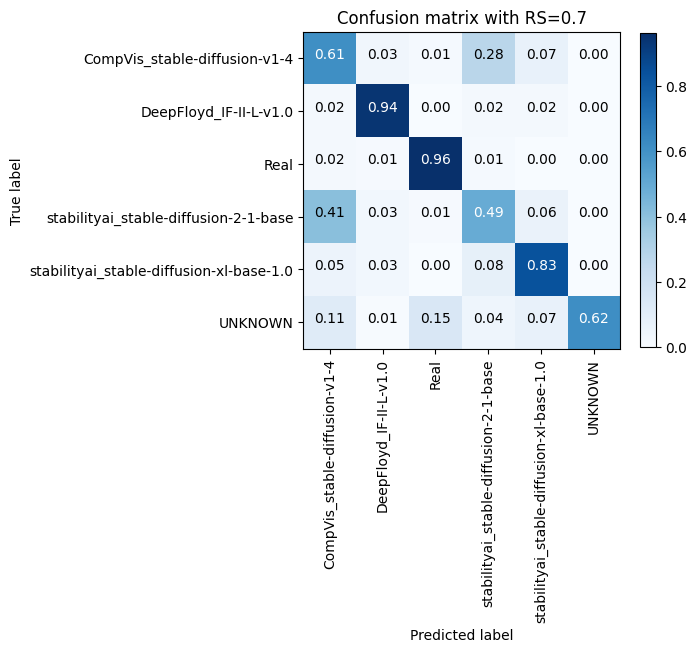

In [19]:
true_labels = np.concatenate((true_labels, r_true_labels))
predicted_labels = np.concatenate((predicted_labels, r_predicted_labels))


conf_matrix = confusion_matrix(true_labels.flatten(), predicted_labels.flatten())
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7,7))
plt.imshow(conf_matrix_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix with RS=' + str(REJ_SCORE))
plt.colorbar(shrink=0.7)

tick_marks = np.arange(NUM_OF_CLASSES)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)

thresh = conf_matrix_norm.max() / 2.

for i, j in itertools.product(range(conf_matrix_norm.shape[0]), range(conf_matrix_norm.shape[1])):
    plt.text(j, i, format(conf_matrix_norm[i, j], '.2f'),
            horizontalalignment="center",
            color="white" if conf_matrix_norm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
